# Spoiler reviews-Capstone

authors: gregor Habeck and Julia Schaefer

In [46]:
#install modules
#!pip install -U nltk
!pip install -U Unidecode
!pip install wordcloud

Requirement already up-to-date: Unidecode in /opt/anaconda3/envs/nf/lib/python3.6/site-packages (1.1.1)


In [143]:
# import modules for data import and editing
import json
import pandas as pd
import gzip
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import time
import operator

# import modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#import modules for text analysis
import spacy
import string
import nltk
from unidecode import unidecode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option("display.max_columns", None)

In [12]:
def import_json_gz(file,limit = 1000000):
    '''
    Function opens and loads a gziped json file and returns a selected number of rows from that file in tabular form.
    Max number of entries: 1 million
    Returns: Pandas Dataframe
    '''
    if limit > 1000000:
        return 'Sorry, your limit is to high. Please choose a number <= 1000000'
    data = []
    count = 0
    with gzip.open(file) as f:
        for l in tqdm(f):
            data_dict = json.loads(l.strip())
            data.append(data_dict)
            count += 1
            if count == limit:
                break
    return pd.DataFrame(data)

In [13]:
# to load the entire dataframe
def import_json_gz2(file):
    '''
    Function opens and loads a gziped json file. Use only for files smaller than 1 GB.
    Max number of entries: 1 million
    Returns: Pandas Dataframe
    '''
    data = []
    with gzip.open(file) as f:
        for l in tqdm(f):
            data_dict = json.loads(l.strip())
            data.append(data_dict)
    return pd.DataFrame(data)

In [14]:
# files that will be used
# file_meta contains meta data for books
file_meta = 'goodreads_books_meta.json.gz'
# file_review contains review texts and additional information
file_reviews = 'goodreads_reviews_spoiler.json.gz'
# file_genre contains genre of books
file_genre = 'goodreads_book_genres_initial.json.gz'

In [15]:
#load a subset of the books meta data to get an idea of what features to extract
df_meta = import_json_gz(file_meta, 10000)

9999it [00:01, 5822.26it/s]


In [16]:
df_meta.head()

,asin,authors,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,isbn,isbn13,kindle_asin,language_code,link,num_pages,popular_shelves,publication_day,publication_month,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,title,title_without_series,url,work_id
0,,"[{'author_id': '604031', 'role': ''}]",4.00,5333265,US,,,Paperback,https://images.gr-assets.com/books/1310220028m...,false,0312853122,9780312853129,,,https://www.goodreads.com/book/show/5333265-w-...,256,"[{'count': '3', 'name': 'to-read'}, {'count': ...",1,9,1984,St. Martin's Press,3,[],[],1,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,https://www.goodreads.com/book/show/5333265-w-...,5400751
1,,"[{'author_id': '626222', 'role': ''}]",3.23,1333909,US,"Anita Diamant's international bestseller ""The ...",Abridged,Audio CD,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743509986,9780743509985,B000FC0PBC,,https://www.goodreads.com/book/show/1333909.Go...,,"[{'count': '2634', 'name': 'to-read'}, {'count...",1,10,2001,Simon & Schuster Audio,10,[],"[8709549, 17074050, 28937, 158816, 228563, 112...",6,Good Harbor,Good Harbor,https://www.goodreads.com/book/show/1333909.Go...,1323437
2,B00071IKUY,"[{'author_id': '10333', 'role': ''}]",4.03,7327624,US,Omnibus book club edition containing the Ladie...,Book Club Edition,Hardcover,https://images.gr-assets.com/books/1304100136m...,false,,,,eng,https://www.goodreads.com/book/show/7327624-th...,600,"[{'count': '58', 'name': 'to-read'}, {'count':...",,,1987,"Nelson Doubleday, Inc.",140,[189911],"[19997, 828466, 1569323, 425389, 1176674, 2627...",7,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,8948723
3,,"[{'author_id': '9212', 'role': ''}]",3.49,6066819,US,Addie Downs and Valerie Adler were eight when ...,,Hardcover,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743294297,9780743294294,B002ENBLOK,eng,https://www.goodreads.com/book/show/6066819-be...,368,"[{'count': '7615', 'name': 'to-read'}, {'count...",14,7,2009,Atria Books,51184,[],"[6604176, 6054190, 2285777, 82641, 7569453, 70...",3282,Best Friends Forever,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,6243154
4,,"[{'author_id': '149918', 'role': ''}]",3.40,287140,US,,,,https://images.gr-assets.com/books/1413219371m...,false,0850308712,9780850308716,,,https://www.goodreads.com/book/show/287140.Run...,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,,,,15,[],[],5,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...,https://www.goodreads.com/book/show/287140.Run...,278577


We consider the following features as usful for EDA and feature engineering:  
    * book_id  
    * title  
    * description  
    * publication_year, publication_month, publication_day  
    * average_rating  
    * ratings_count  
    * num_pages  

In [17]:
def check_features(features, dataset):
    '''
    simple way to check if selected features are in a dataset
    '''
    for f in features:
        if f not in dataset.columns:
            return f'{f} is not a valid column name'
    return 'Good to go!'

In [18]:
#generator to open json.gzip files
# yields single lines
def get_book(file):
    '''
    Generator will yield lines of the passed file
    '''
    with gzip.open(file, 'r') as f:
        for l in f:
            yield l

# fetch features
def fetch_features(file, features, book_list):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a dictionary.
    
    File: json.gzip file you want to scan
    
    Features: features to extract
    
    book_list: set of book_ids
    '''
    
    feature_dict = defaultdict(list)    
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        
        try:
            if book_id in book_list:
                for f in features:
                    feature_dict[f].append(book_dict.get(f))
        except: 
            pass
        
    return feature_dict

In [19]:
def fetch_one_feature(file, f):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a list.
    '''
    
    feature = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        feature.append(book_dict.get(f))
    
    return feature

In [20]:
book_ids =fetch_one_feature(file_reviews, 'book_id')
book_ids_unique = book_ids
print(f'Number of reviews: {len(book_ids)}')
book_ids=set(book_ids)
print(f'The dataset contains reviews for {len(book_ids)} books.')

1378033it [00:40, 33908.06it/s]


Number of reviews: 1378033
The dataset contains reviews for 25475 books.


In [21]:
# get book ids from review file
# features: list containing features we want to extract from the book-meta data file
features = ['book_id', 'title', 'description', 'publication_year', 'publication_month', 
            'publication_day', 'average_rating', 'ratings_count', 'num_pages']
check_features(features, df_meta)

'Good to go!'

In [22]:
book_meta_features = pd.DataFrame.from_dict(fetch_features(file_meta, features, book_ids))

2360655it [03:29, 11247.11it/s]


In [23]:
book_meta_features.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,,,,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3,5,4.36,1759,
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8,1,4.04,6049,400
9,9469517,Mercy,,2009,2,1,3.64,3559,226


In [24]:
book_meta_features.shape

(25475, 9)

In [25]:
book_meta_features.isna().sum()

book_id              0
title                0
description          0
publication_year     0
publication_month    0
publication_day      0
average_rating       0
ratings_count        0
num_pages            0
dtype: int64

Going back to data source, we figured out that missing values are empty strings (''). We will use the replace function to replace missing values with np.nan.

In [26]:
# replace '' (missing values) with na
book_meta_features2 = book_meta_features.copy()
book_meta_features2 = book_meta_features2.replace('', np.nan)
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3,5,4.36,1759,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8,1,4.04,6049,400
9,9469517,Mercy,NaN,2009,2,1,3.64,3559,226


In [27]:
#missing values
df_b_m = pd.DataFrame({
    'missing_count':book_meta_features2.isnull().sum()
})
df_b_m['missing_rel'] = round(df_b_m.missing_count/len(book_meta_features2),2)*100
df_b_m

,missing_count,missing_rel
book_id,0,0.0
title,0,0.0
description,305,1.0
publication_year,3084,12.0
publication_month,3605,14.0
publication_day,4183,16.0
average_rating,1,0.0
ratings_count,1,0.0
num_pages,2002,8.0


In [28]:
# what is the data type of the different features
# in the original data it looks like all features are saved as strings
book_meta_features.dtypes

book_id              object
title                object
description          object
publication_year     object
publication_month    object
publication_day      object
average_rating       object
ratings_count        object
num_pages            object
dtype: object

In [29]:
# replace average_rating, rating_count and num_pages as int
to_transform = ['publication_year','publication_month', 'publication_day','average_rating','ratings_count', 'num_pages' ]
for f in to_transform:
    book_meta_features2[f]=pd.to_numeric(book_meta_features2[f], errors='coerce')

In [30]:
book_meta_features2.dtypes

book_id               object
title                 object
description           object
publication_year     float64
publication_month    float64
publication_day      float64
average_rating       float64
ratings_count        float64
num_pages            float64
dtype: object

In [31]:
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014.0,10.0,6.0,3.71,1525.0,351.0
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017.0,7.0,25.0,4.19,693.0,384.0
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008.0,6.0,1.0,3.41,3852.0,210.0
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011.0,6.0,7.0,3.98,252.0,8.0
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010.0,3.0,23.0,3.88,1675.0,245.0
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023.0,340.0
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017.0,3.0,5.0,4.36,1759.0,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012.0,1.0,1.0,4.10,289.0,402.0
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011.0,8.0,1.0,4.04,6049.0,400.0
9,9469517,Mercy,NaN,2009.0,2.0,1.0,3.64,3559.0,226.0


In [32]:
book_meta_features2['weighted_average_rating']=book_meta_features2.average_rating*book_meta_features2.ratings_count

In [33]:
book_meta_features2.head(2)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014.0,10.0,6.0,3.71,1525.0,351.0,5657.75
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017.0,7.0,25.0,4.19,693.0,384.0,2903.67


In [34]:
#load whole genre dataset
genre = import_json_gz2(file_genre)

171922it [00:01, 103944.54it/s]


KeyboardInterrupt: 

In [ ]:
genre.head()

In [ ]:
genre.shape

The genre dataset contains genre information for 2.3 million books. However, according to the [data source](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/reviews) we have reviews for 25k  books. We will use the function below to get the genres for the books contained in the review data set. Note that the genres are provided as a dictionary. The following function will also identify book_ids which have not been asigned a genre.

In [35]:
def fetch_genre(file, book_list):
    '''
    File: json.gzip file you want to scan
    
    book_list: set of book_ids
    
    Returns: list containing book_ids and genres and a list of book_ids with no information on genre
    '''
    
    book_genres = []    
    missing_genre = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        book_genre = book_dict.get('genres')
        try:
            if book_id in book_list:
                book_genres.append(book_dict) 
                # empty dictionary returns 
                if not book_genre:
                    missing_genre.append(book_id)
        except: 
            pass
        
    return book_genres, missing_genre

In [36]:
genre, missing_genre = fetch_genre(file_genre,book_ids)

2360655it [00:17, 134394.04it/s]


In [37]:
missing_genre

['16148398']

In [38]:
df_genre = pd.DataFrame(genre)

In [39]:
df_genre.head()

,book_id,genres
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'..."
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,..."
2,2741853,"{'romance': 555, 'fiction': 61}"
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ..."
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri..."


In [40]:
df_genre.shape

(25475, 2)

In [41]:
# function to get key from dictionary with highest value or ordered list
# returns None if dictionary is empty and max() will cause an error
import operator
def get_genre(x):
    try:
        
        a= max(x.items(), key=operator.itemgetter(1))[0]
        b = sorted(x.items(), key=operator.itemgetter(1))
        return a
    except:
        return np.nan

In [42]:
# create new colum containing genre with most votes (from users)
df_genre['best_genre'] = df_genre['genres'].apply(lambda x:get_genre(x))

In [43]:
df_genre.head()

,book_id,genres,best_genre
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'...",young-adult
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,...",romance
2,2741853,"{'romance': 555, 'fiction': 61}",romance
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ...",fiction
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri...",romance


In [44]:
df_genre.isnull().sum()

book_id       0
genres        0
best_genre    1
dtype: int64

In [45]:
# identify book with missing genre
df_missing_genre = df_genre[df_genre.best_genre.isnull()]
df_missing_genre

,book_id,genres,best_genre
16474,16148398,{},NaN


In [46]:
missing_book = book_meta_features2[book_meta_features2.book_id == '16148398']
missing_book

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating
16474,16148398,Saga #1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We seem to have no infomration but the title for the book with the missing genre. Check how often this book was reviewd using the book ids.

In [47]:
i = 0
for book in book_ids_unique:
    if book == '16148398':
        i += 1
print(f' The book "Saga #1" was reviewed {i} time(s)')

 The book "Saga #1" was reviewed 1 time(s)


As this book was only reviewed once, we will drop this book.

In [48]:
books_to_drop = ['16148398']

In [49]:
# load the reviews data
t0 = time.time()
df_reviews = import_json_gz2(file_reviews)
elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

1378033it [01:52, 12287.65it/s]


'00:02:02'

In [50]:
# get a quick look at the reviews data
df_reviews.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id
0,18245960,True,5,dfdbb7b0eb5a7e4c26d59a937e2e5feb,"[[0, This is a special book.], [0, It started ...",2017-08-30,8842281e1d1347389f2ab93d60773d4d
1,16981,False,3,a5d2c3628987712d0e05c4f90798eb67,"[[0, Recommended by Don Katz.], [0, Avail for ...",2017-03-22,8842281e1d1347389f2ab93d60773d4d
2,28684704,True,3,2ede853b14dc4583f96cf5d120af636f,"[[0, A fun, fast paced science fiction thrille...",2017-03-20,8842281e1d1347389f2ab93d60773d4d
3,27161156,False,0,ced5675e55cd9d38a524743f5c40996e,"[[0, Recommended reading to understand what is...",2016-11-09,8842281e1d1347389f2ab93d60773d4d
4,25884323,True,4,332732725863131279a8e345b63ac33e,"[[0, I really enjoyed this book, and there is ...",2016-04-25,8842281e1d1347389f2ab93d60773d4d


In [51]:
# merge datatframes
df_all = df_reviews.merge(book_meta_features2, on='book_id' ).merge(df_genre, on= 'book_id')
df_all.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating,genres,best_genre
0,18245960,True,5,dfdbb7b0eb5a7e4c26d59a937e2e5feb,"[[0, This is a special book.], [0, It started ...",2017-08-30,8842281e1d1347389f2ab93d60773d4d,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
1,18245960,False,3,b88eb6519a046159a31afcc21a448b6f,"[[0, Average between the 4 star concepts (over...",2015-10-21,1a2398eca437fed5d9add310a0c09611,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
2,18245960,False,5,5ea837edf3b1386c613a123f46e1cccd,"[[0, A really refreshing take on science ficti...",2017-05-22,ab19fd8bcc1021d1c0f42dfa8d47f1e3,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
3,18245960,True,1,cefa3a787e1a845fb48acad37ff528de,"[[0, I'm really waffling between whether to ra...",2015-07-10,e956ca90ba23174bbbccf1161ab19150,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
4,18245960,True,5,86a7c0571fd59e729cf9e2340dda1224,"[[0, Every time I read a good science fiction ...",2016-07-30,da7a0c5ee0c89973224d8853445be68e,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction


In [52]:
# save dataframe
#df_all.to_csv('complete_data.csv', chunksize=10000)

In [53]:
# split into train, val and test dataset (70:20:10)
df_train, df_validate, df_test = \
              np.split(df_all.sample(frac=1, random_state=42), 
                       [int(.7*len(df_all)), int(.9*len(df_all))])

In [ ]:
print(df_train.shape, df_validate.shape, df_test.shape)

In [ ]:
#save train, val and test dataset as csv files
t0 = time.time()

df_train.to_json('training_set.json', orient = 'index')
df_validate.to_json('validation_set.json', orient = 'index')
df_test.to_json('test_set.json', orient = 'index')

elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [3]:
# test import 
t0 = time.time()
df_train = pd.read_json('training_set.json', orient = 'index')
elapsed_time = time.time()-t0
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


00:08:26


NameError: name 'test' is not defined

In [8]:
df_train.shape

(964623, 18)

In [5]:
# functions to isolate labels and text from review_sentences column
def get_sentence_label(x):
    return [label for label, text in x]
def get_sentence_text(x):
    return [text for label, text in x]

In [7]:
# for the spell checking we will start with a smaller sub set 
# we only take reviews that contain spoilers
df_spoilers = df_train.copy()
df_spoilers = df_spoilers[df_spoilers['has_spoiler'] == True]
df_spoilers.shape

(62815, 18)

In [9]:
df_spoilers['sentence_labels'] = df_spoilers.review_sentences.apply(lambda x: get_sentence_label(x))
df_spoilers['sentence_texts'] = df_spoilers.review_sentences.apply(lambda x: get_sentence_text(x))

In [85]:
df_spoilers.head()

,average_rating,best_genre,book_id,description,genres,has_spoiler,num_pages,publication_day,publication_month,publication_year,rating,ratings_count,review_id,review_sentences,timestamp,title,user_id,weighted_average_rating,sentence_labels,sentence_texts
859048,3.92,young-adult,13517455,"Five years ago, Wren Connolly was shot three t...","{'young-adult': 1025, 'fiction': 633, 'romance...",1,365.0,7.0,5.0,2013.0,5,23778.0,5b942fa92ca26d999063758098d36742,"[[0, Review originally posted at Step Into Fic...",2013-04-11,"Reboot (Reboot, #1)",883e2e0ae9de4c2c46c0fb09d6025fdf,93209.76,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Review originally posted at Step Into Fiction...
1079332,4.39,"comics, graphic",13620,Although they've collected plenty of evidence ...,"{'comics, graphic': 854, 'fantasy, paranormal'...",1,215.0,5.0,7.0,2006.0,4,15486.0,e493d9ef493603381cd1241349c37381,"[[0, This is an interesting volume in which L ...",2016-12-01,"Death Note, Vol. 6: Give-and-Take (Death Note,...",8811d75d39ef5d4dd88a3e209cf005b4,67983.54,"[0, 1, 1, 0]",[This is an interesting volume in which L lear...
135626,4.28,"fantasy, paranormal",16096824,Feyre's survival rests upon her ability to hun...,"{'fantasy, paranormal': 10725, 'young-adult': ...",1,416.0,5.0,5.0,2015.0,4,182581.0,b2b8f14ccadc67149f0bb4838398ff00,"[[0, I'm actually surprised at how much I enjo...",2017-07-31,A Court of Thorns and Roses (A Court of Thorns...,e6bc867b9841ae70809e26fcbdd2517e,781446.68,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[I'm actually surprised at how much I enjoyed ...
885360,3.67,romance,658351,Nothing is more seductive than temptation.\nRe...,"{'history, historical fiction, biography': 600...",1,480.0,9.0,5.0,2000.0,2,3950.0,9ac2bd80782fb527af31780e1b7bd149,"[[0, OK, from the date and comments I've read ...",2011-12-28,"Potent Pleasures (Pleasures, #1)",669857f1fadc9d247effababbbfbe334,14496.50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[OK, from the date and comments I've read abou..."
802134,4.09,"mystery, thriller, crime",25526965,The spectacular finale to the New York Times b...,"{'fiction': 662, 'mystery, thriller, crime': 1...",1,432.0,7.0,6.0,2016.0,5,37011.0,a2107f3ae8c571ec5143e25a5039171c,"[[1, The best one of the three book-series - p...",2016-09-19,"End of Watch (Bill Hodges Trilogy, #3)",9eb4a3eddac3760571020b5a49136f87,151374.99,[1],[The best one of the three book-series - partl...


## Spell checking using 

In [10]:
# install Sympspell and pyspellchecker
! pip install pyspellchecker
!python -m pip install -U symspellpy

Requirement already up-to-date: symspellpy in /opt/anaconda3/envs/nf/lib/python3.6/site-packages (6.7.0)


In [11]:
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
import pkg_resources


In [86]:
# this is just an example to see how Spellchecker works
spell = SpellChecker()
spell = SpellChecker(distance = 1)
misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])
for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))
    print(spell.candidates(word))


hapenning
{'hapenning'}


In [87]:
#example for symspell
# get path to dictionary with typical word frequecies
import pkg_resources
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")

symspell = SymSpell()
#load dictionary
symspell.load_dictionary(dictionary_path, term_index=0, count_index=1)


True

In [14]:
results = symspell.lookup('happenning', Verbosity.CLOSEST)
for r in results:
    print(r)

happening, 1, 11920756


In [79]:
test_sentences = [sen for sen in df_spoilers.sentence_texts]
test_sentences2 = [sen for sublist in test_sentences for sen in sublist]

In [81]:
test_sentences2[:20]

['Review originally posted at Step Into Fiction',
 'I want to be rebooted.',
 "I'm just not sure if I want to be a lower number or a higher number.",
 "I'm leaning toward a higher number just because they are a bit more kickass.",
 'The higher the number means the longer you were dead before you rebooted.',
 "The longer you've been dead, the less human emotions you carry over with you.",
 'The more likely you are to stay alive but the easier you are for HARC to use you...',
 'This book was so awesome.',
 "I absolutely love Wren; everything about her from her lack of emotions, to her amazing fighting skills, to her twisted way of thinking (at times), to just how much she changes from the beginning of this book until the end but doesn't lose herself along the way.",
 'Reboot starts off with you following Wren on one of her assignments, arresting humans and returning them to HARC so they can receive their punishment, whatever that is.',
 "Right away, you're drawn in to Wren and find yours

In [82]:
# processing input text

from unidecode import unidecode
punctuation = '!"#%$\()*+,-./:;>=<?@[\\]^_{}|~'
def preprocessing1(text):
    # convert to lower
    text = text.lower().replace("\n", " ").replace("\t", " ")
    #remove punctation
    text = text.translate(str.maketrans('', '', punctuation))
    #remove non-ascii characters
    text = unidecode(text)
    return text

In [83]:
test_sentences2 = [preprocessing1(s) for s in test_sentences2]

In [84]:
test_sentences2[:20]

['review originally posted at step into fiction',
 'i want to be rebooted',
 "i'm just not sure if i want to be a lower number or a higher number",
 "i'm leaning toward a higher number just because they are a bit more kickass",
 'the higher the number means the longer you were dead before you rebooted',
 "the longer you've been dead the less human emotions you carry over with you",
 'the more likely you are to stay alive but the easier you are for harc to use you',
 'this book was so awesome',
 "i absolutely love wren everything about her from her lack of emotions to her amazing fighting skills to her twisted way of thinking at times to just how much she changes from the beginning of this book until the end but doesn't lose herself along the way",
 'reboot starts off with you following wren on one of her assignments arresting humans and returning them to harc so they can receive their punishment whatever that is',
 "right away you're drawn in to wren and find yourself being curious to 

In [77]:
test_sentences2_misspelled = [spell.unknown(s.split(' ')) for s in test_sentences2]

In [89]:
test_sentences2_misspelled[:20]

[set(),
 {'rebooted'},
 {"i'm"},
 {"i'm", 'kickass'},
 {'rebooted'},
 {"you've"},
 {'harc'},
 set(),
 {"doesn't"},
 {'harc'},
 {'backstory', "you're"},
 set(),
 {'reboots'},
 {'rebooted', "we're"},
 {''},
 set(),
 {'newbies'},
 {"there's"},
 set(),
 set()]

In [ ]:
#for word cloud

In [91]:
sentences_wc = []
labels = []
for row in df_spoilers.review_sentences:
    for label, text in row:
        labels.append(label)
        sentences_wc.append(text)

In [122]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopset = nltk.corpus.stopwords.words('english') 
lemmatizer = WordNetLemmatizer() 


def preprocessing1(text):
    # convert to lower
    text = text.lower().replace("\n", " ").replace("\t", " ")
    #remove punctation
    text = text.translate(str.maketrans('', '', punctuation))
    # remove stopwords
    text = " ".join([lemmatizer.lemmatize(i) for i in word_tokenize(text) if i not in stopset])
    #remove non-ascii characters
    text = unidecode(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gregor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gregor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [130]:
sentences_wc_processed = [preprocessing1(sen) for sen in tqdm(sentences_wc)]

100%|██████████| 1500305/1500305 [05:13<00:00, 4791.13it/s]


In [133]:
df_spoiler_text = pd.DataFrame({
    'sentences': sentences_wc,
    'sentences_processed':sentences_wc_processed,
    'labels':labels
    
})

In [157]:
#text_no_spoiler = " ".join(list(df_spoiler_text.sentences_processed[df_spoiler_text.labels  == 0]))
text_spoiler = " ".join(df_spoiler_text.sentences_processed[df_spoiler_text.labels  == 1])

In [161]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")

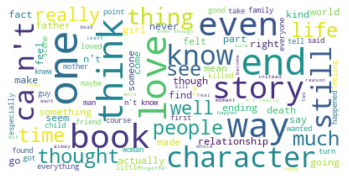

In [162]:
wordcloud_s = wordcloud.generate(text_spoiler)
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis("off")
plt.show()

In [156]:
wordcloud_no_s = WordCloud().generate(text_no_spoiler)

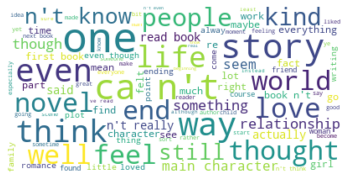

In [163]:
wordcloud_no_s = wordcloud.generate(text_no_spoiler)
plt.imshow(wordcloud_no_s, interpolation='bilinear')
plt.axis("off")
plt.show()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 1,  6,  5],
        [ 4, 16, 16],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [ ]:
sen = df_spoiler.review_sentences

In [ ]:
length=[]
for s in sen:
    length.append(len(s))

In [ ]:
len(length)

In [ ]:
plt.hist(length, bins = 30)


In [ ]:
sen2 = df_no_spoiler.review_sentences
length2=[]
for s in sen2:
    length2.append(len(s))
plt.hist(length2, bins = 30)

In [ ]:
print(np.mean(length))
print(np.mean(length2))